# Exercise 3: Adiabatic Pulse Design


For our third exercise, let's take on adiabatic pulse design with SigPy. Adiabatic pulses are a special class of RF pulses that can excite, refocus, or invert magnetization vectors uniformly, even in the presence of a spatially nonuniform $B_1$ field. This makes them a good choice for tricky imaging problems; they can overcome issues such as inhomogeneity resulting from the use of a surface coil. A critical difference between these pulses and the pulses we have previously designed is that adiabatic pulses do *not* follow the typical proportionality relationship between flip angle and $B_1$ amplitude. Instead, the flip angle depends on modulation of both the amplitude and frequency of the pulse.

Again, before diving into the exercise, we begin with our import statements.

In [1]:
%matplotlib notebook

# typical sigpy and numpy imports
import numpy as np
import sigpy.mri.rf as rf # import for our RF pulse design tools 
import sigpy.plot as pl

import matplotlib.pyplot as pyplot

## Problem 3a: BIR-4 adiabatic excitation

We will first perform a BIR-4 ($B_1$-Independent Rotation) adiabatic excitation pulse design. This is the most commonly used type of BIR pulse, as it induces a plane rotation more accurately than other BIR pulses and typically requires less power. A BIR-4 pulse consists of four piecewise-defined segments of AM and FM modulation.

SigPy has one function that will create all 4 of these segments: [*rf.adiabatic.bir4()*](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.rf.adiabatic.bir4.html#sigpy.mri.rf.adiabatic.bir4).

* Design a pulse that:
    * Has a flip angle of 90 degrees ($\pi$/2 radians)
    * Has a duration of 4.7 ms (given a hardware dwell time of 4e-6 s)
    * Provides roughly uniform excitation between 0.1 and 1 Gauss


* You will need to:
    * Select beta (AM) and kappa (FM) adiabatic parameters, to determine how closely the adiabatic condition is met
    * Apply the rf.adiabatic.bir4() function to design the pulse
* A tolerence factor used to allow for off-resonance, dw0, is already provided.

In [2]:
# Design it:

# our adiabatic parameters:
n = 1176
dt = 4e-6  # hardware dwell time
dw0 = 100*np.pi/dt/n  # tolerance factor, to allow for off-resonace
beta = 10  # dimensionless AM constant,determines how well adiabatic condition is met
kappa = np.arctan(20)  # dimensionless FM constant, determines how well adiabtic condition is met
flip = np.pi/2  # flip angle in radians

# Perform our BIR-4 pulse design
[am_bir, om_bir] = rf.adiabatic.bir4(n, beta, kappa, flip, dw0)  

<IPython.core.display.Javascript object>


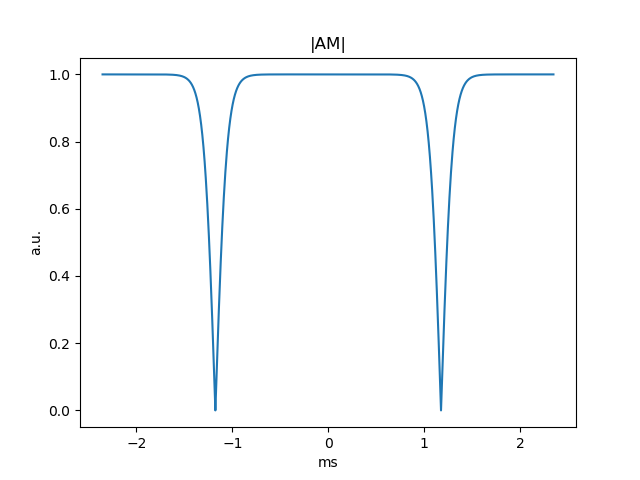

<IPython.core.display.Javascript object>


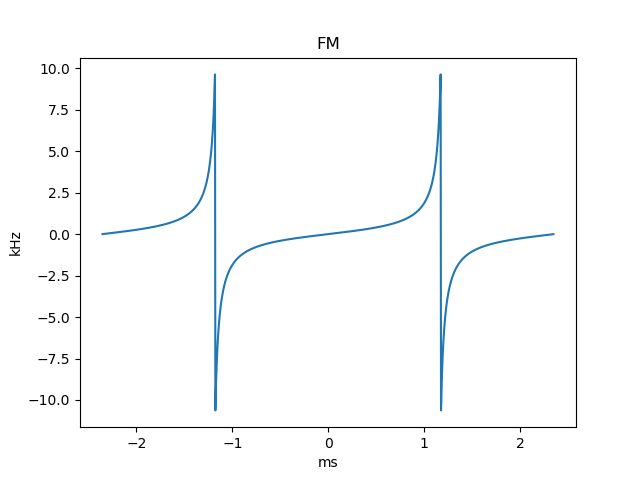

Text(0.5, 1.0, 'FM')

In [3]:
# Plot it: AM and FM modulation waveforms
T = n*dt
t = np.arange(-T/2,T/2,dt)*1000
pyplot.figure()
pyplot.plot(t, np.abs(am_bir))
pyplot.xlabel('ms')
pyplot.ylabel('a.u.')
pyplot.title('|AM|')
pyplot.figure()
pyplot.plot(t, om_bir/(2*np.pi*1000))
pyplot.xlabel('ms')
pyplot.ylabel('kHz')
pyplot.title('FM')

<IPython.core.display.Javascript object>


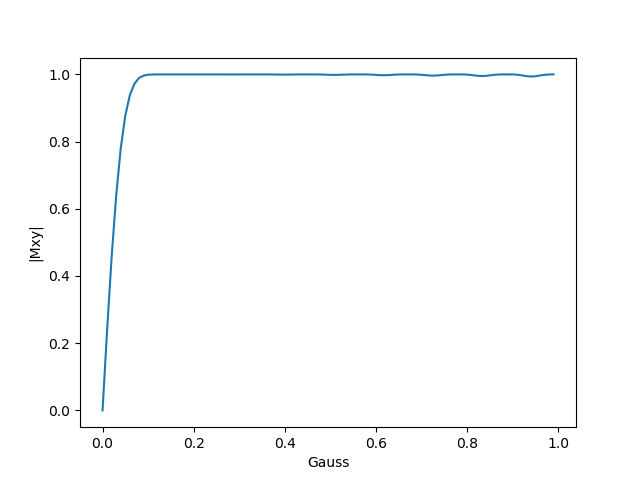

Text(0, 0.5, '|Mxy|')

In [4]:
# Simulate it across B1 amplitudes
b1 = np.arange(0, 1, 0.01) # b1 grid we simulate the pulse over, Gauss
b1 = np.reshape(b1, (np.size(b1),1))
a = np.zeros(np.shape(b1), dtype = 'complex')
b = np.zeros(np.shape(b1), dtype = 'complex')
for ii in range(0, np.size(b1)):
    [a[ii], b[ii]] = rf.sim.abrm_nd(2*np.pi*dt*4258*b1[ii]*am_bir, np.ones(1), dt*np.reshape(om_bir,(np.size(om_bir),1)))
Mxy = 2*np.multiply(np.conj(a), b)
pyplot.figure()
pyplot.plot(b1, np.abs(Mxy))
pyplot.xlabel('Gauss')
pyplot.ylabel('|Mxy|')

You should see that, as expected, once the adiabatic threshold is met (requiring a certain minimum B1) the magnetization is excited regardless of B1 amplitude!

## Problem 3b: Hyperbolic Secant Inversion Pulse

Next, let's perform adiabatic inversion by designing a hyperbolic secant pulse. The documentation for designing this type of adiabatic pulse can be found [here](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.rf.adiabatic.hypsec.html#sigpy.mri.rf.adiabatic.hypsec).

* Design a pulse that:
    * Has a flip angle of 180 degrees ($\pi$ radians)
    * Has a duration of 4 ms (given a hardware dwell time of 4e-6 s).
    * Provides roughly uniform inversion between 0.1 and 1 Gauss


* You will need to:
    * Select beta (AM) and mu (FM) adiabatic parameters, to determine how closely the adiabatic condition is met.
        * Values of beta on the order of magnitude from 100's to 1000's are typical.
        * Values of mu on the order of 10's to 100's are typical.
    * Apply the [*rf.adiabatic.hypsec()*](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.rf.adiabatic.hypsec.html#sigpy.mri.rf.adiabatic.bir4) function to design the pulse. 
    * Use [*rf.sim.abrm_nd()*]() within a loop to simulate the pulse across a range of B1 amplitudes.

In [5]:
# Design it using hypsec()
n = 2002
beta = 500
mu = 60
T = 0.012
[am_sech, om_sech] = rf.adiabatic.hypsec(n, beta, mu, T)

<IPython.core.display.Javascript object>


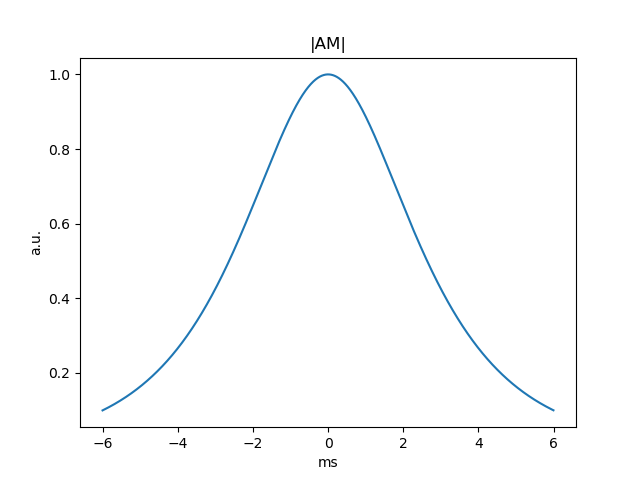

<IPython.core.display.Javascript object>


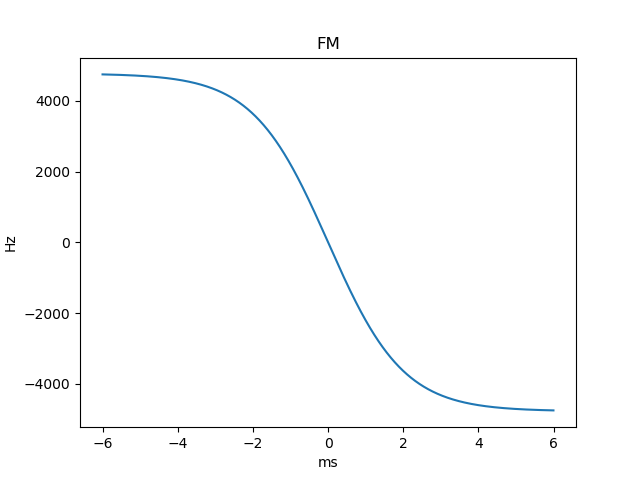

Text(0.5, 1.0, 'FM')

In [6]:
# Plot it
t = np.arange(-T/2,T/2,T/n)*1000
pyplot.figure()
pyplot.plot(t, np.abs(am_sech))
pyplot.xlabel('ms')
pyplot.ylabel('a.u.')
pyplot.title('|AM|')
pyplot.figure()
pyplot.plot(t, om_sech/(2*np.pi))
pyplot.xlabel('ms')
pyplot.ylabel('Hz')
pyplot.title('FM')

<IPython.core.display.Javascript object>


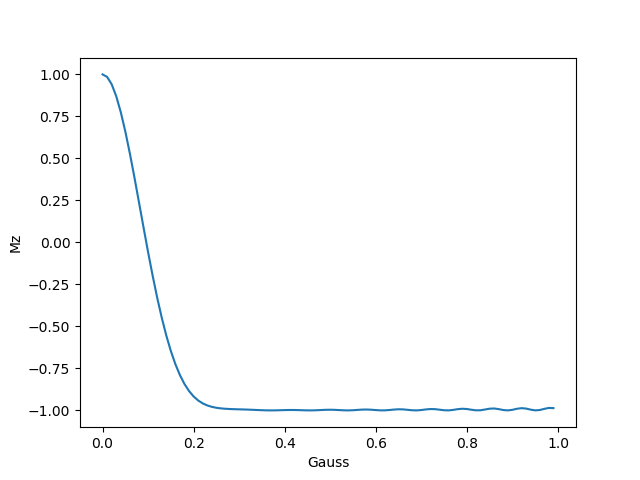

Text(0, 0.5, 'Mz')

In [7]:
# Simulate it
a = np.zeros(np.shape(b1), dtype = 'complex')
b = np.zeros(np.shape(b1), dtype = 'complex')
for ii in range(0, np.size(b1)):
    [a[ii], b[ii]] = rf.sim.abrm_nd(2*np.pi*(T/n)*4258*b1[ii]*am_sech, np.ones(1), T/n*np.reshape(om_sech,(np.size(om_sech),1)))
Mz = 1-2*np.abs(b)**2
pyplot.figure()
pyplot.plot(b1, Mz)
pyplot.xlabel('Gauss')
pyplot.ylabel('Mz')

This time you should see that once the adiabatic threshold is met the magnetization is inverted to -1 regardless of B1 amplitude!